In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud

from tensorflow.keras.preprocessing.text import Tokenizer

np.random.seed(19)

In [2]:
train = pd.read_hdf(r'datasets\dummy_train.h5', key='df')
test = pd.read_hdf(r'datasets\dummy_test.h5', key='df')

print(f"Train shape: {train.shape}, Test shape: {test.shape}")

Train shape: (240000, 4), Test shape: (60000, 4)


In [3]:
train.head()

,Id,Title,Body,Tags
2530000,2530001,SQL Filtering based on Calculated Time Slots,<p>Im making a simple booking system for our p...,sql sql-server asp.net-mvc query tsql
1403686,1403687,What sort of errors can lead to session data b...,<p>I'm experiencing a strange error with my ca...,php session cakephp load-balancing
2470612,2470613,Convert nmake makefile into Visual Studio 2005...,<p>We have some old C code here that's built w...,c visual-studio-2005 nmake
309905,309906,HUGE query execution time difference between o...,<p>I'm running the following query:</p>\n\n<pr...,oracle query-optimization data-dictionary
4079679,4079680,Image on start up / loading,"<p>I ma developing an app, which at the moment...",android image loading oncreate


Let us make some basic cleaning - drop duplicate rows from a dataframe, and drop rows that contain NaNs

In [4]:
train = train.drop_duplicates()
train = train.dropna()

print(f"Train set shape after basic cleanup: {train.shape}")

Train set shape after basic cleanup: (239999, 4)


Looks like one duplicate or nan was in our train data

As we've seen, we can have couple of target values for our data, as it is on Stack Exchange

In [5]:
labels = train.Tags
print(labels[:10])

2530000        sql sql-server asp.net-mvc query tsql
1403686           php session cakephp load-balancing
2470612                   c visual-studio-2005 nmake
309905     oracle query-optimization data-dictionary
4079679               android image loading oncreate
2015342                                jquery jqgrid
1049287                                  java string
5779089                          php javascript html
5932339                                 java xml xsd
4999631           c++ code-quality language-agnostic
Name: Tags, dtype: object


To build a tagging system like that, we need to construct a model for multi-label classification. It basically means that the model can give multiple classes to the observation, not just one

Let's first check how many labels do we really have in our data

In [6]:
all_classes = [item.split(' ') for item in labels.values]
all_classes = [subitem for sublist in all_classes for subitem in sublist]

In [7]:
c = Counter(all_classes)
print(f"Total number of labels in our data: {len(c)}")

Total number of labels in our data: 24918


Text(0.5, 0, 'Tag ordinal number')

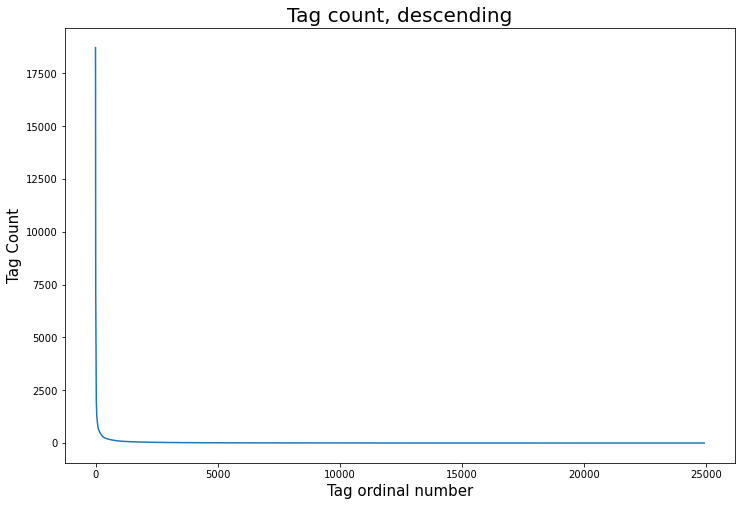

In [8]:
plt.figure(figsize=(12,8))
plt.plot(sorted(c.values(), reverse=True))
plt.title("Tag count, descending", fontsize=20)
plt.ylabel('Tag Count', fontsize=15)
plt.xlabel('Tag ordinal number', fontsize=15)

And we see that the majority of tags occurs very rarely. Let's extract only 500 most common tags from the data

In [9]:
count_vectorizer = CountVectorizer(max_features=500, token_pattern = '[a-zA-Z0-9$&+,:;=?@#|<>.^*()%!-]+')
labels_transformed = count_vectorizer.fit_transform(labels.values)
labels_transformed

<239999x500 sparse matrix of type '<class 'numpy.int64'>'
	with 428014 stored elements in Compressed Sparse Row format>

CountVectorizer class sotres the data in sparse matrix format to save space. It is a convenient data structure where majority of cells are zeros, which it happens to be like that in this case. Each column represents one of the output classes, and row represents one observations in our data. For example, if each observation has something like 4-5 tags, each row has aproximately 495 zeros.

We can print what are the features in our CountVectorizer

In [10]:
features = count_vectorizer.get_feature_names()
features[:10]

['.htaccess',
 '.net',
 '.net-3.5',
 '.net-4.0',
 '2010',
 '3d',
 'abstract-algebra',
 'actionscript',
 'actionscript-3',
 'active-directory']

Let's see how many tags on average our observations have

In [11]:
count = labels_transformed.sum(axis=1)
count = count.flatten().tolist()[0]


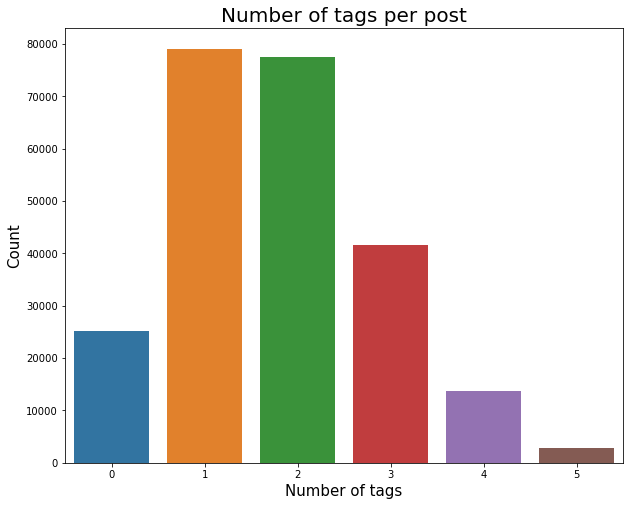

In [12]:
plt.figure(figsize=(10, 8))
sns.countplot(count)
plt.xlabel('Number of tags', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title("Number of tags per post", fontsize=20)
plt.show()


We see that mostly, our questions have one or 2 tags (taking into account that we took 500 most cocuring tags)

Let's now count features

In [13]:
count = labels_transformed.sum(axis=0)
count = count.flatten().tolist()[0]

In [14]:
mapping = dict(zip(features, count))

In [15]:
mapping = {k:v for k, v in sorted(mapping.items(), key=lambda item: item[1], reverse=True)}

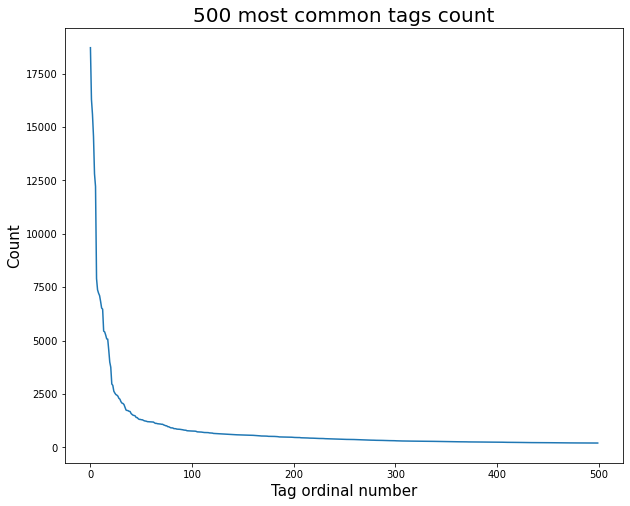

In [16]:
plt.figure(figsize=(10, 8))
plt.plot(list(mapping.values())[:500])
plt.xlabel('Tag ordinal number', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title("500 most common tags count", fontsize=20)
plt.show()


Still, the majority of most occuring 500 tags is preserved in few tags

Let's take into account tags that occur more than 1000 times

In [17]:
threshold = 1000
mapping = {k: v for k, v in mapping.items() if v >= threshold}
list(mapping.items())[:10]

[('c#', 18720),
 ('java', 16297),
 ('php', 15600),
 ('javascript', 14571),
 ('android', 12809),
 ('jquery', 12220),
 ('c++', 7902),
 ('python', 7375),
 ('iphone', 7217),
 ('asp.net', 7102)]

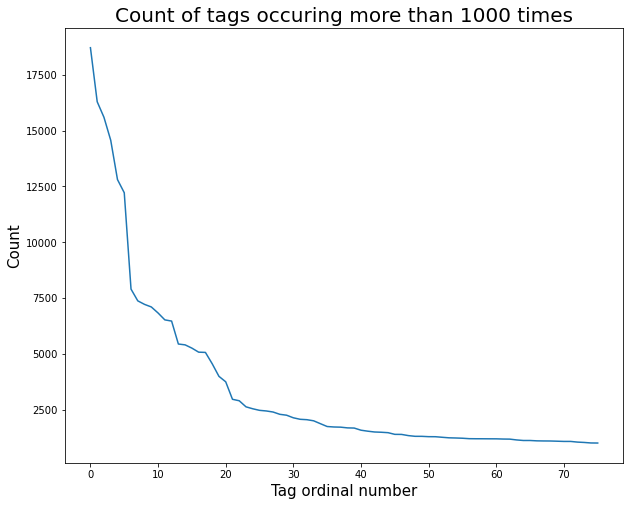

In [18]:
plt.figure(figsize=(10, 8))
plt.plot(list(mapping.values()))
plt.xlabel('Tag ordinal number', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title("Count of tags occuring more than 1000 times", fontsize=20)
plt.show()

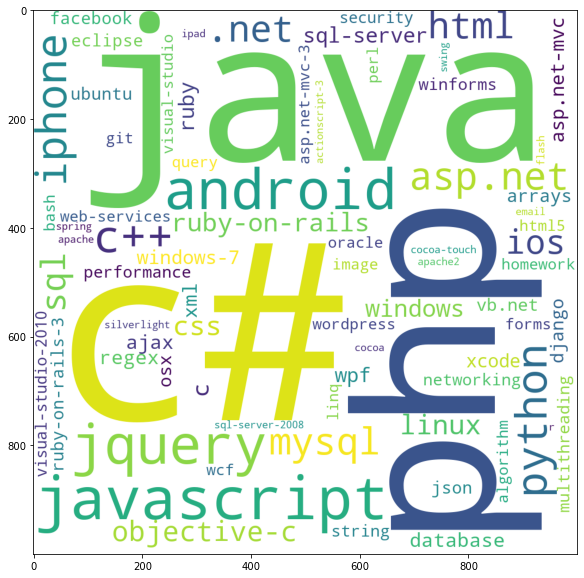

In [19]:

plt.figure(figsize=(16, 10))
wc = WordCloud(background_color="white",width=1000,height=1000, max_words=500,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(mapping)
plt.imshow(wc)

Let's plot 20 most common tags

In [20]:
top_20_tags = list(mapping.items())[:20]
top_20_counts = [tag[1] for tag in top_20_tags]
top_20_words = [tag[0] for tag in top_20_tags]

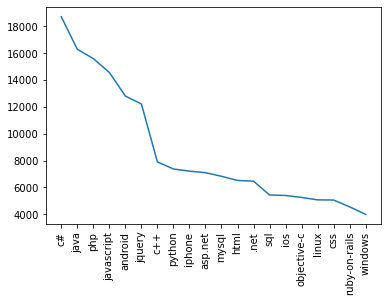

In [21]:
plt.plot(top_20_counts)
plt.xticks(range(20), top_20_words, rotation='vertical')
plt.show()

TRAINING

In [22]:
titles = train.Title.values
bodies = train.Body.values
tags = train.Tags.values

In [23]:
train.head(2)

,Id,Title,Body,Tags
2530000,2530001,SQL Filtering based on Calculated Time Slots,<p>Im making a simple booking system for our p...,sql sql-server asp.net-mvc query tsql
1403686,1403687,What sort of errors can lead to session data b...,<p>I'm experiencing a strange error with my ca...,php session cakephp load-balancing


In [24]:
print(bodies[1])

<p>I'm experiencing a strange error with my cakePHP application. The users to this application occasionally are authenticated incorrectly and are able to view a different user's profile information on their page. I know this is a very open ended question, and without code should be hard to get a specific answer, but I'm wondering what sort of general problems could lead to this sort of behavior, and if anyone on SO could lead me in the right direction. It seems like it should be a common enough problem, but I can't find any literature about it.</p>

<p>My application is behind a load balancer, which might have the potential for weird behavior with the session, but I'm under the impression that this is not the case.</p>



In [25]:
input_data = [' '.join([title, body]) for title, body in zip(titles, bodies)]

In [26]:
VOCAB_SIZE = 2000

tokenizer = Tokenizer(num_words = VOCAB_SIZE)

tokenizer.fit_on_texts(input_data)

In [27]:
input_data_encoded = tokenizer.texts_to_matrix(input_data)

In [28]:
num_tags = 100

count_vectorizer = CountVectorizer(max_features=num_tags, token_pattern = '[a-zA-Z0-9$&+,:;=?@#|<>.^*()%!-]+')
labels_transformed = count_vectorizer.fit_transform(labels.values).toarray()

Let's try a simple feed forward architecture to check how are we doing on this data

In [159]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow import keras

model = Sequential()
model.add(layers.Dense(512, input_shape=(VOCAB_SIZE,), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(num_tags, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = [keras.metrics.Precision(name='precision'),
              keras.metrics.Recall(name='recall'),
              keras.metrics.AUC(name='auc'),
              ])

In [160]:
model.fit(input_data_encoded, labels_transformed, epochs=20, batch_size=128, validation_split=0.1)

Epoch 1/20
1688/1688 [==============================] - 14s 8ms/step - loss: 0.0681 - precision: 0.1768 - recall: 0.2436 - auc: 0.8754 - val_loss: 0.0288 - val_precision: 0.7644 - val_recall: 0.3430 - val_auc: 0.9570
Epoch 2/20
1688/1688 [==============================] - 14s 8ms/step - loss: 0.0288 - precision: 0.7205 - recall: 0.3951 - auc: 0.9574 - val_loss: 0.0262 - val_precision: 0.7436 - val_recall: 0.4171 - val_auc: 0.9639
Epoch 3/20
1688/1688 [==============================] - 13s 8ms/step - loss: 0.0259 - precision: 0.7383 - recall: 0.4422 - auc: 0.9666 - val_loss: 0.0256 - val_precision: 0.7460 - val_recall: 0.4261 - val_auc: 0.9652
Epoch 4/20
1688/1688 [==============================] - 14s 8ms/step - loss: 0.0238 - precision: 0.7501 - recall: 0.4783 - auc: 0.9730 - val_loss: 0.0255 - val_precision: 0.7393 - val_recall: 0.4386 - val_auc: 0.9635
Epoch 5/20
1688/1688 [==============================] - 14s 9ms/step - loss: 0.0218 - precision: 0.7639 - recall: 0.5184 - auc: 0.97

In [163]:
test_titles, test_bodies = test.Title, test.Body
test_labels = test.Tags

In [164]:
input_data = [' '.join([title, body]) for title, body in zip(test_titles, test_bodies)]

input_data_encoded = tokenizer.texts_to_matrix(input_data)

test_labels_transformed = count_vectorizer.transform(test_labels.values).toarray()


In [165]:
model.evaluate(input_data_encoded, test_labels_transformed)


1875/1875 [==============================] - 7s 4ms/step - loss: 0.0503 - precision: 0.5857 - recall: 0.5008 - auc: 0.8764


[0.050253186374902725,
 0.5857056379318237,
 0.5007855892181396,
 0.8764448165893555]

Our model generalized, however, the performance is not very satisfactory and some further experiments should be held. However, we will make them in a systematic way using some knwon tools in the industry.

In [166]:
# END??????

In [29]:
import pickle
with open('count_vectorizer.pck', 'wb') as handle:
    pickle.dump(count_vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [169]:
import pickle
with open('tokenizer.pck', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [168]:
model.save(r'models\feedforward_model.h5')

In [48]:
tokenizer_titles = Tokenizer()
tokenizer_bodies = Tokenizer()

In [39]:
tokenizer_titles.fit_on_texts(titles.tolist())
tokenizer_bodies.fit_on_texts(bodies.tolist())

In [41]:
titles_encoded = tokenizer_titles.texts_to_sequences(titles)
bodies_encoded = tokenizer_bodies.texts_to_sequences(bodies)

In [42]:
MAX_LEN_titles = 20
MAX_LEN_bodies = 100

In [43]:
titles_padded = pad_sequences(titles_encoded, maxlen=MAX_LEN_bodies)
bodies_padded = pad_sequences(bodies_encoded, maxlen=MAX_LEN_bodies)

In [44]:
from tensorflow.keras import layers
from tensorflow import keras

In [45]:
words_titles = len(tokenizer_titles.word_counts)+1
words_bodies = len(tokenizer_bodies.word_counts)+1

In [46]:
num_tags = 100

In [47]:
MAX_LEN_titles

20

In [48]:
MAX_LEN_bodies

100

In [49]:
count_vectorizer = CountVectorizer(max_features=num_tags, token_pattern = '[a-zA-Z0-9$&+,:;=?@#|<>.^*()%!-]+')
labels_transformed = count_vectorizer.fit_transform(labels.values)

In [307]:
# # title_input = keras.Input(shape=(MAX_LEN_titles))
# # bodies_input = keras.Input(shape=(MAX_LEN_bodies))

# # embedding_titles = layers.Embedding(input_dim=words_titles, output_dim=64)(title_input)
# # embedding_bodies = layers.Embedding(input_dim=words_bodies, output_dim=64)(bodies_input)

# # lstm_titles = layers.LSTM(16)(embedding_titles)
# # lstm_bodies = layers.LSTM(32)(embedding_bodies)

# # concat = layers.concatenate([lstm_titles, lstm_bodies])

# # dense = layers.Dense(256, activation='relu')(concat)
# # drop = layers.Dropout(0.5)(dense)
# # tags = layers.Dense(num_tags, activation='sigmoid')(drop)

# title_input = keras.Input(shape=(MAX_LEN_bodies))
# bodies_input = keras.Input(shape=(MAX_LEN_bodies))

# embedding_titles = layers.Embedding(input_dim=words_titles, output_dim=64)(title_input)
# embedding_bodies = layers.Embedding(input_dim=words_bodies, output_dim=64)(bodies_input)

# cnn_titles = layers.Conv1D(64, kernel_size=7, activation='relu')(embedding_titles)
# cnn_bodies = layers.Conv1D(64, kernel_size=7, activation='relu')(embedding_bodies)

# concat = layers.concatenate([cnn_titles, cnn_bodies], axis=-1)

# cnn = layers.Conv1D(64, kernel_size=7, activation='relu')(concat)

# flatten = layers.Flatten()(cnn)

# dense = layers.Dense(256, activation='relu')(flatten)
# drop = layers.Dropout(0.5)(dense)
# tags = layers.Dense(num_tags, activation='sigmoid')(drop)

In [308]:
# model = keras.Model(
#     inputs=[title_input, bodies_input],
#     outputs=[tags],
# )

In [302]:
labels_vec = labels_transformed.toarray()

In [219]:
import tensorflow_addons as tfa
from tensorflow_addons.metrics.hamming import hamming_loss_fn, HammingLoss
from sklearn.metrics import hamming_loss

In [304]:
labels_vec = labels_vec.astype(np.float32)

In [303]:
labels_vec.shape

(239999, 100)

In [309]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[
        'binary_crossentropy',
    ],
    metrics = [keras.metrics.Precision(name='precision'),
              keras.metrics.Recall(name='recall'),
              keras.metrics.AUC(name='auc'),
              ]
    
)

In [310]:
history = model.fit([titles_padded, bodies_padded], labels_vec, epochs=2, batch_size=32, validation_split=0.2)

Epoch 1/2
6000/6000 [==============================] - 1522s 254ms/step - loss: 0.0486 - precision: 0.6957 - recall: 0.0862 - auc: 0.8489 - val_loss: 0.0402 - val_precision: 0.8069 - val_recall: 0.1636 - val_auc: 0.8994
Epoch 2/2
6000/6000 [==============================] - 1508s 251ms/step - loss: 0.0406 - precision: 0.7902 - recall: 0.1754 - auc: 0.9004 - val_loss: 0.0388 - val_precision: 0.8151 - val_recall: 0.1869 - val_auc: 0.9113


In [311]:
history = model.fit([titles_padded, bodies_padded], labels_vec, epochs=2, batch_size=32, validation_split=0.2)

Epoch 1/2
6000/6000 [==============================] - 1476s 246ms/step - loss: 0.0403 - precision: 0.8005 - recall: 0.1882 - auc: 0.9030 - val_loss: 0.0395 - val_precision: 0.8434 - val_recall: 0.1773 - val_auc: 0.9075
Epoch 2/2
6000/6000 [==============================] - 1478s 246ms/step - loss: 0.0409 - precision: 0.8060 - recall: 0.1842 - auc: 0.9011 - val_loss: 0.0397 - val_precision: 0.8545 - val_recall: 0.1615 - val_auc: 0.9030


In [268]:
# model.save(r'models\simple_lstm_two_inputs')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models\simple_lstm_two_inputs\assets


In [242]:
test = pd.read_hdf(r'datasets\dummy_test.h5', key='df')

In [243]:
test.head()

,Id,Title,Body,Tags
1052590,1052591,Is there anyway to use MySQL's LOAD XML LOCAL ...,<p>with this type of XML format?</p>\n\n<pre><...,mysql xml load local infile
4841054,4841055,GPO refresh error - Policy Refresh has not com...,"<p>I'm having problem with my GPO changes, tha...",windows windows-server-2003 active-directory g...
541743,541744,UAC thinks my Application is an installer Part 2,<p>I have been trying to deal with the Windows...,installer windows-server-2003 uac manifest
5006435,5006436,Poor performance when holding down accelerator...,<p>I have bound a menu item to invoke the undo...,java performance swing hotkeys accelerator
4822115,4822116,How do I configure/make/install against an old...,<p>I'm trying to install a piece of software (...,linux osx unix make compilation


In [253]:
count_vectorizer = CountVectorizer(max_features=num_tags, token_pattern = '[a-zA-Z0-9$&+,:;=?@#|<>.^*()%!-]+')
labels_transformed = count_vectorizer.fit_transform(labels.values)

In [244]:
y_test = test.Tags

In [254]:
y_test = count_vectorizer.transform(y_test.values)

In [255]:
test_titles = test.Title.values
test_bodies = test.Body.values

In [256]:
test_titles = tokenizer_titles.texts_to_sequences(test_titles)
test_bodies = tokenizer_bodies.texts_to_sequences(test_bodies)

In [257]:
test_titles = pad_sequences(test_titles, maxlen=MAX_LEN_titles)
test_bodies = pad_sequences(test_bodies, maxlen=MAX_LEN_bodies)

In [260]:
y_labels = y_test.toarray()

In [261]:
model.evaluate([test_titles, test_bodies], y_labels)

1875/1875 [==============================] - 10s 5ms/step - loss: 0.0353 - precision: 0.8298 - recall: 0.2203 - auc: 0.9225


[0.03526732325553894,
 0.8298198580741882,
 0.22033612430095673,
 0.9225457906723022]

In [263]:
a = model.predict([test_titles[:2], test_bodies[:2]])

In [266]:
a[1].shape

(100,)

In [267]:
a[0].sum()

0.83449024

In [264]:
a

array([[0.00718424, 0.00594637, 0.00959061, 0.00365167, 0.00166285,
        0.00731318, 0.01337482, 0.01384696, 0.00701527, 0.00739616,
        0.00725046, 0.00254973, 0.00133239, 0.00384083, 0.00147757,
        0.02098291, 0.001426  , 0.00111864, 0.00059226, 0.00132645,
        0.01786144, 0.00322755, 0.00223436, 0.00465925, 0.01776487,
        0.00082463, 0.00525453, 0.00674454, 0.00293122, 0.0017031 ,
        0.01039312, 0.00732048, 0.00392562, 0.00202317, 0.00152655,
        0.00771669, 0.0014986 , 0.01010236, 0.00187979, 0.00709753,
        0.0027952 , 0.00086522, 0.00318694, 0.00077387, 0.00369275,
        0.05015795, 0.01822655, 0.00497737, 0.00035632, 0.00563828,
        0.00083686, 0.01528627, 0.00115929, 0.00131075, 0.01842277,
        0.00393211, 0.00447604, 0.00258893, 0.00189547, 0.003303  ,
        0.00819276, 0.00678587, 0.0053345 , 0.15512003, 0.01167346,
        0.00379423, 0.0015087 , 0.00766095, 0.03065283, 0.03697919,
        0.01077668, 0.01413924, 0.00263043, 0.00

In [ ]:
# hl = HammingLoss(mode='multilabel', threshold=0.8)

# def hamming_loss2(y_true, y_pred, mode='multilabel'):
#     if mode not in ['multiclass', 'multilabel']:
#         raise TypeError('mode must be: [None, multilabel])')

#     if mode == 'multiclass':
#         nonzero = tf.cast(tf.math.count_nonzero(y_true * y_pred, axis=-1), tf.float32)
#         return 1.0 - nonzero

#     else:
#         nonzero = tf.cast(tf.math.count_nonzero(y_true - y_pred, axis=-1), 
#             tf.float32)
#         return nonzero / y_true.get_shape()[-1]
    
# # model.compile(
# #     optimizer=keras.optimizers.RMSprop(1e-3),
# #     loss=[
# #         hamming_loss2,
# #     ]
# # )

# hl = HammingLoss(mode='multilabel', threshold=0.8)

# from functools import partial

# phamming = partial(hamming_loss_fn, mode='multilabel', threshold=0.8)

In [108]:
num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = keras.Input(
    shape=(None,), name="title"
)  # Variable-length sequence of ints
body_input = keras.Input(shape=(None,), name="body")  # Variable-length sequence of ints
tags_input = keras.Input(
    shape=(num_tags,), name="tags"
)  # Binary vectors of size `num_tags`

# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])

# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, name="priority")(x)
# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, name="department")(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred],
)